**Model 3:**

Here we introduced cutout Regularization and the rest of the Hyperparameters were set to the same as Model 2. 

Installing required packages 

In [ ]:
pip install torch torchvision


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing necessary modules:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


Defining the ModifiedResNet and BasicBlock classes

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(BasicBlock, self).__init__()
        # The first convolution layer in the residual block with kernel_size=3, stride=stride, padding=1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # Batch normalization after the first convolution layer
        self.bn1 = nn.BatchNorm2d(out_channels)
        # ReLU activation function
        self.relu = nn.ReLU(inplace=True)
        # The second convolution layer in the residual block with kernel_size=3, stride=1, padding=1
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # Batch normalization after the second convolution layer
        self.bn2 = nn.BatchNorm2d(out_channels)
        # The downsample layer is needed when the input and output channels are different or when the stride is not 1
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ModifiedResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedResNet, self).__init__()
        # Initial convolution layer with kernel_size=3, stride=1, padding=1, and 32 output channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        # Batch normalization after the initial convolution layer
        self.bn1 = nn.BatchNorm2d(32)
        # ReLU activation function
        self.relu = nn.ReLU(inplace=True)
        # First residual layer with 32 input channels, 32 output channels, and 3 residual blocks
        self.layer1 = self._make_layer(32, 32, 3, stride=1)
        # Second residual layer with 32 input channels, 64 output channels, and 4 residual blocks
        self.layer2 = self._make_layer(32, 64, 4, stride=2)
        # Third residual layer with 64 input channels, 128 output channels, and 4 residual blocks
        self.layer3 = self._make_layer(64, 128, 4, stride=2)
        # Fourth residual layer with 128 input channels, 256 output channels, and 3 residual blocks
        self.layer4 = self._make_layer(128, 256, 3, stride=2)
        # Adaptive average pooling to reduce spatial dimensions to 1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer with 256 input features and num_classes output features
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = ModifiedResNet()

#We've increased the number of residual layers and modified the input and output channels to adapt the architecture 
#for better feature extraction.


Set up the device (use GPU if available):

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Defining data augmentation and normalization:

In [ ]:
transform_train = transforms.Compose([
    # This helps the model generalize better by learning to recognize objects in different positions within the image
    transforms.RandomCrop(32, padding=4),
    
    # This helps the model generalize better by learning to recognize objects in different orientations
    transforms.RandomHorizontalFlip(),
    
    # This helps the model generalize better by learning to recognize objects at different angles
    transforms.RandomRotation(15),
    
    # This helps the model generalize better by learning to recognize objects under various lighting conditions and color transformations
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    
    # Normalize the image using the mean and standard deviation of the CIFAR-10 dataset
    # This helps the model converge faster during training by ensuring input values have similar magnitudes
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    
    # Normalize the image using the mean and standard deviation of the CIFAR-10 dataset
    # This ensures the test data has the same distribution as the training data
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


Using Cutout regularization:

The cutout file contains 


import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img


In [ ]:
from cutout import Cutout

transform_train.transforms.append(Cutout(n_holes=1, length=16))


Loading the CIFAR-10 dataset:

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:05<00:00, 29257315.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Instantiate the model, loss function, and optimizer:

model.parameters(): This function call returns the trainable parameters of the model, which will be optimized by the optimizer.

lr=1e-3: This sets the learning rate to 0.001, which is a common value for Adam and AdamW optimizers. The learning rate determines the step size used during the optimization process. A good learning rate allows the model to converge faster without overshooting the optimal parameter values.

weight_decay=1e-4: Weight decay is a regularization technique that prevents overfitting by adding a penalty term to the loss function. This penalty term is proportional to the L2 norm of the model's weights. A weight decay value of 1e-4 is a common choice for regularization in deep learning models. It helps improve generalization without causing a significant drop in model capacity.

In [ ]:
model = ModifiedResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)


Define the learning rate scheduler:

In [ ]:
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)


num_params = sum(p.numel() for p in model.parameters())print(f"Number of parameters: {num_params}")

 Number of parameters: 4735658

Training the model:

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch: {epoch+1}, Loss: {running_loss/(i+1)}, Train accuracy: {100*correct/total}")

    scheduler.step()


Epoch: 1, Loss: 1.704723521266752, Train accuracy: 36.852
Epoch: 2, Loss: 1.3718007153562268, Train accuracy: 50.16
Epoch: 3, Loss: 1.197223674153428, Train accuracy: 57.042
Epoch: 4, Loss: 1.0748443492233295, Train accuracy: 61.686
Epoch: 5, Loss: 0.9788733107964401, Train accuracy: 65.29
Epoch: 6, Loss: 0.9079649439248283, Train accuracy: 67.814
Epoch: 7, Loss: 0.8392236952281669, Train accuracy: 70.184
Epoch: 8, Loss: 0.7970619402882998, Train accuracy: 72.124
Epoch: 9, Loss: 0.7494431830123257, Train accuracy: 73.626
Epoch: 10, Loss: 0.7204372595490702, Train accuracy: 74.678
Epoch: 11, Loss: 0.6920044583737698, Train accuracy: 75.642
Epoch: 12, Loss: 0.6617913487012429, Train accuracy: 76.842
Epoch: 13, Loss: 0.6329369535836418, Train accuracy: 77.846
Epoch: 14, Loss: 0.6149489744697385, Train accuracy: 78.512
Epoch: 15, Loss: 0.5953494881272621, Train accuracy: 79.136
Epoch: 16, Loss: 0.5791920477624439, Train accuracy: 79.456
Epoch: 17, Loss: 0.5614677537280275, Train accuracy: 

Testing the model:

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test accuracy: {100*correct/total}")


Test accuracy: 93.55


We had to hard code the epoch details for 3 models because we ran out of computational memory required to run the model once again with the graph code embedded in it. 


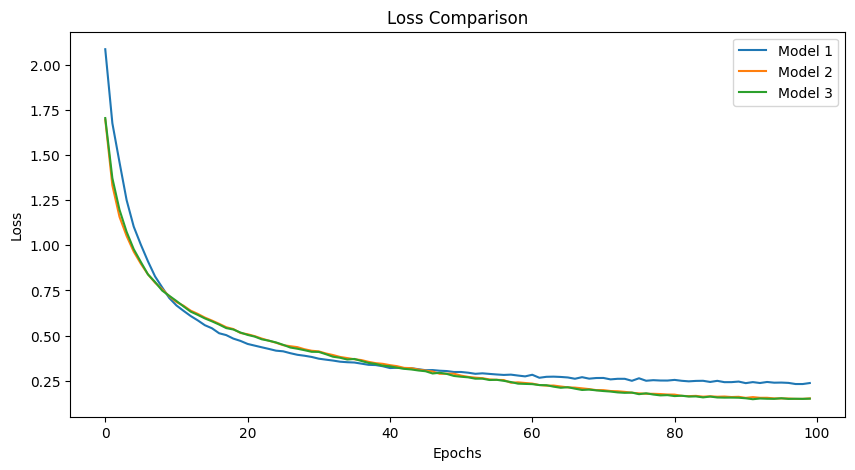

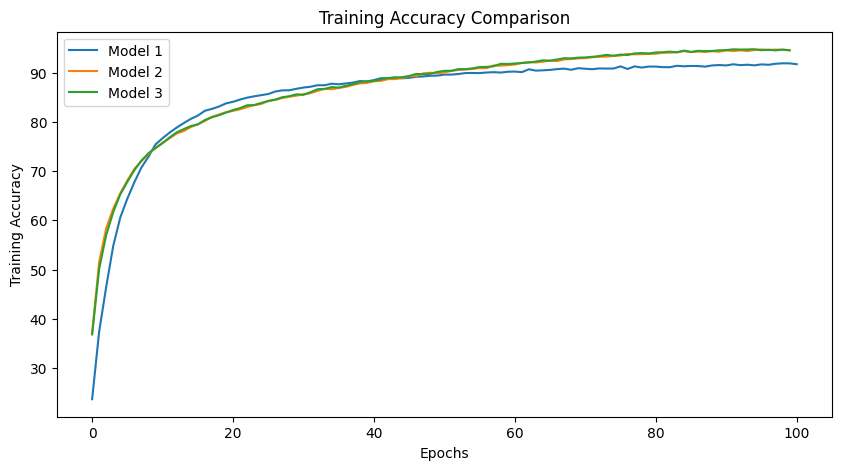

In [ ]:
import matplotlib.pyplot as plt

# Data for Model 1
model1_loss = [2.085784676738761, 1.6759634840894828, 1.4603323939849029, 1.2505592922256752, 1.10368228669871, 1.003720301118764, 0.9114242409440604, 0.8278325725008141, 0.7670673512938347, 0.7081148137592457, 0.6673356741666794, 0.6374069205061956, 0.6088407468897375, 0.5844868937168609, 0.5577307285910303, 0.5407064121047204, 0.5132802022113041, 0.5029763847758825, 0.48361601219089195, 0.47087380256165157, 0.45419011502103374, 0.44478445072573697, 0.43548778173598374, 0.4264131497845731, 0.41682140939784323, 0.41328105770728807, 0.4028822214511985, 0.39399911247363145, 0.388740547509356, 0.3821064880625768, 0.372501235878603, 0.367128419986164, 0.36207925337790087, 0.3557801135731014, 0.3528828846544705, 0.35121087975461374, 0.34496523774313653, 0.3384844970212064, 0.3371267668818208, 0.3305614000101658, 0.32064208007332956, 0.3220561788502065, 0.31935943087393587, 0.31963144475594163, 0.3143700042062185, 0.30877338303253055, 0.3094182149930434, 0.3058452023701234, 0.3039481869729405, 0.29880169131369755, 0.2987953785552897, 0.29484629398211837, 0.2886850068938326, 0.29140911977314815, 0.2881074025380341, 0.28503927279433067, 0.28251539496704936, 0.2841515941333703, 0.27907477503388445, 0.274462446147068, 0.28344653447327967, 0.26677523930133745, 0.27215568827126513, 0.2729775412431495, 0.27132073703052645, 0.26848826299167494, 0.26132826905020257, 0.2700818979012018, 0.2618642948694866, 0.2654566979247399, 0.26576237636618316, 0.25781697648662055, 0.2610859134530818, 0.2610083627514541, 0.2499662570613013, 0.26399398485029285, 0.25025312862866983, 0.25350131356919353, 0.2515666683797132, 0.25134156413630326, 0.25501653949984093, 0.25000356903977017, 0.24700725722041997, 0.24941447008909148, 0.250074948776852, 0.2436175396327268, 0.24980177144011992, 0.24248210435987197, 0.2426264913202348, 0.24572649435140193, 0.23707369300113482, 0.24277624712240967, 0.2377494702919979, 0.24354606661522252, 0.2395697057204829, 0.24018926738592034, 0.23843322615985843, 0.2321274141484702, 0.2320730123372579, 0.2376177295280451]
model1_train_acc = [23.7, 37.45777777777778, 46.522222222222226, 54.84444444444444, 60.611111111111114, 64.41777777777777, 67.75111111111111, 70.73555555555555, 72.91333333333333, 75.42, 76.67333333333333, 77.80888888888889, 78.82888888888888, 79.72666666666667, 80.58444444444444, 81.25777777777778, 82.23333333333333, 82.61555555555556, 83.1, 83.7311111111111, 84.06, 84.51555555555555, 84.89555555555556, 85.17111111111112, 85.40444444444445, 85.63777777777777, 86.14888888888889, 86.38, 86.39777777777778, 86.69777777777777, 86.95111111111112, 87.11333333333333, 87.41777777777777, 87.41777777777777, 87.73555555555555, 87.60666666666667, 87.78, 87.94666666666667, 88.27111111111111,88.18666666666667, 88.46222222222222, 88.8488888888889, 88.86666666666666, 88.99777777777778, 88.82444444444444, 88.92444444444445, 89.13111111111111, 89.20444444444445, 89.35111111111111, 89.37555555555555, 89.58, 89.57777777777778, 89.70666666666666, 89.89111111111112, 89.90444444444445, 89.88222222222223, 90.00666666666666, 90.06888888888889, 89.9888888888889, 90.16, 90.19111111111111, 90.08666666666667, 90.65333333333334, 90.38222222222223, 90.45111111111112, 90.53111111111112, 90.69111111111111, 90.7911111111111, 90.55777777777777, 90.88, 90.76444444444445, 90.67333333333333, 90.82888888888888, 90.80222222222223, 90.81111111111112, 91.24888888888889, 90.71555555555555, 91.25333333333333, 91.00444444444445, 91.20666666666666, 91.20444444444445, 91.0911111111111, 91.08222222222223, 91.36666666666666, 91.2688888888889, 91.33111111111111, 91.31555555555556, 91.19555555555556, 91.43333333333334, 91.51777777777778, 91.43555555555555, 91.67777777777778, 91.49333333333334, 91.58666666666667, 91.45333333333333, 91.65555555555555, 91.56888888888889, 91.77777777777777, 91.86888888888889, 91.86, 91.68666666666667]


# Data for Model 2
model2_loss = [1.696396364885218, 1.3318028007931721, 1.158014152360999, 1.0519595659907213, 0.9651200972554629, 0.8982390179048718, 0.8393398878519492, 0.7930788335287967, 0.7572673431137944, 0.7176882324316313, 0.686328514000339, 0.6657198053949019, 0.6383969003282239, 0.6204934155239779, 0.5999529958533509, 0.583392344624795, 0.5656560574803511, 0.5467571050614652, 0.5365527199052483, 0.5146085789898778, 0.5078753265730865, 0.49719115420985405, 0.48374260744780223, 0.4719821540900813, 0.46068735607444783, 0.44722765855624547, 0.44154746552257584, 0.43639089247149887, 0.4246612264372199, 0.4164117073159084, 0.41293973565254066, 0.40133662944864434, 0.3926681227162671, 0.38207588765932166, 0.37587510975425503, 0.369413030193285, 0.3647740468420946, 0.35494408282020207, 0.3476526393457447, 0.3439537142320057, 0.3366858732822301, 0.33105579186278533, 0.3215599611896993, 0.3200459893402236, 0.31222821737799195, 0.3064021242930151, 0.30136875202283836, 0.28882962469097295, 0.2893871565342254, 0.2894126224281538, 0.2786393874822675, 0.2717272610310703, 0.2674561431035971, 0.2644264380759595, 0.25757670796969356, 0.2552333406513304, 0.2542382353711921, 0.2393523485344999, 0.2414581422000895, 0.23786720799286956, 0.23461350253628344, 0.22658364476678927, 0.22314355684363324, 0.22385378037114886, 0.2185242259136551, 0.21361503974937113, 0.21231482029342286, 0.20839007205479895, 0.20401648163338146, 0.198427995490601, 0.1983117798481451, 0.19344771521932938, 0.19214568418615005, 0.1887391962091941, 0.18391063037659505, 0.18053837757929206, 0.17800201138343347, 0.17807234257764523, 0.17665475543083436, 0.17414730888269747, 0.17357376760915114, 0.16658946927017568, 0.16520958755860854, 0.16656457426031226, 0.16218197244741117, 0.16430850235549996, 0.1618385747875399, 0.16295101703204157, 0.1601437389221795, 0.16144881472753747, 0.1555124195125859, 0.15975537737045448, 0.15586612512693382, 0.15601839412889823, 0.1525609991930025, 0.15257639202582257, 0.1519674405436534, 0.14988485201621604, 0.15006139953537365, 0.1525136471899879]
model2_train_acc = [37.144, 51.562, 58.414, 62.406, 65.498, 68.108, 70.44, 72.034, 73.454, 74.694, 75.788, 76.646, 77.64, 78.11, 78.944, 79.486, 80.162, 80.96, 81.468, 81.958, 82.206, 82.544, 82.99, 83.376, 83.626, 84.24, 84.448, 84.81, 85.1, 85.294, 85.568, 85.812, 86.278, 86.674, 86.618, 86.866, 87.078, 87.47, 87.778, 87.876, 88.24, 88.308, 88.654, 88.662, 88.876, 89.24, 89.278, 89.832, 89.954, 89.834, 90.018, 90.33, 90.524, 90.6, 90.722, 90.906, 90.872, 91.434, 91.394, 91.494, 91.622, 91.942, 92.126, 92.042, 92.206, 92.404, 92.318, 92.652, 92.744, 92.86, 92.926, 93.1, 93.208, 93.226, 93.354, 93.448, 93.762, 93.686, 93.726, 93.776, 93.804, 94.034, 94.02, 94.144, 94.332, 94.168, 94.264, 94.172, 94.326, 94.22, 94.5, 94.358, 94.498, 94.358, 94.546, 94.676, 94.584, 94.654, 94.608, 94.51]

# Data for Model 3
model3_loss = [1.704723521266752, 1.3718007153562268, 1.197223674153428, 1.0748443492233295, 0.9788733107964401, 0.9079649439248283, 0.8392236952281669, 0.7970619402882998, 0.7494431830123257, 0.7204372595490702, 0.6920044583737698, 0.6617913487012429, 0.6329369535836418, 0.6149489744697385, 0.5953494881272621, 0.5791920477624439, 0.5614677537280275, 0.5417570131818962, 0.534012662632691, 0.5172154651121106, 0.5041401149976589, 0.49475369070801894, 0.47963355302505783, 0.4719901939334772, 0.46235030813290334, 0.44920849053146283, 0.4342571881116199, 0.427532623795902, 0.41944317653051116, 0.4105976875252126, 0.41001529145576154, 0.39730756605982476, 0.38341678560847214, 0.37755874435767495, 0.36782006831730113, 0.37104000273110616, 0.3597577982546423, 0.34897690866609365, 0.3432397907194884, 0.3339081208419312, 0.330189191167007, 0.3227616739471245, 0.3162966401833098, 0.31278965033381184, 0.30712737085874126, 0.3029800665271861, 0.2905487905987693, 0.29448667122884786, 0.28811574647265015, 0.2768692786202711, 0.27255041039813205, 0.26917633418079534, 0.2617472005660272, 0.26184517354763986, 0.254416203369265, 0.2555928586998864, 0.24972389569825224, 0.24311620067528752, 0.2341729070791198, 0.23277963736020696, 0.2315884129813565, 0.22634905578611453, 0.22558728527382513, 0.2175359673359815, 0.21140937653877545, 0.2143745523832186, 0.20653301286880318, 0.19927087006971356, 0.2013502523417363, 0.1970940597564973, 0.19328559773123782, 0.19047383337145876, 0.18576897614066254, 0.18336291907502866, 0.18481694108537397, 0.1759673502496289, 0.18086610620131577, 0.17404445045439484, 0.1692979522239979, 0.17066441036170096, 0.16542495249787256, 0.1673930038690872, 0.1628212925246762, 0.16356186042813695, 0.15816196384827805, 0.16271517423870008, 0.1577216999800614, 0.15680710490211805, 0.15704872858379504, 0.15629641094323618, 0.1532200280186313, 0.14801578630533668, 0.15202762752466495, 0.15061007227624773, 0.15011258058421448, 0.1533540002334758, 0.14982189054188827, 0.15056394430263267, 0.1499706389253859, 0.15108777089115907]
model3_train_acc = [36.852, 50.16, 57.042, 61.686, 65.29, 67.814, 70.184, 72.124, 73.626, 74.678, 75.642, 76.842, 77.846, 78.512, 79.136, 79.456, 80.362, 80.94, 81.34, 81.862, 82.382, 82.786, 83.356, 83.39, 83.822, 84.218, 84.512, 84.988, 85.194, 85.58, 85.48, 86.008, 86.614, 86.676, 87.042, 86.936, 87.304, 87.62, 88.068, 88.188, 88.27, 88.598, 88.856, 88.956, 89.06, 89.302, 89.716, 89.642, 89.74, 90.126, 90.346, 90.354, 90.692, 90.684, 90.852, 91.116, 91.136, 91.288, 91.764, 91.732, 91.832, 91.94, 92.024, 92.228, 92.476, 92.4, 92.646, 92.9, 92.866, 93.02, 93.064, 93.188, 93.344, 93.582, 93.416, 93.636, 93.556, 93.878, 93.946, 93.86, 94.076, 94.102, 94.242, 94.086, 94.46, 94.162, 94.4, 94.35, 94.374, 94.504, 94.544, 94.708, 94.662, 94.676, 94.728, 94.526, 94.618, 94.49, 94.654, 94.518]


plt.figure(figsize=(10, 5))
plt.plot(model1_loss, label="Model 1")
plt.plot(model2_loss, label="Model 2")
plt.plot(model3_loss, label="Model 3")  # Add this line for Model 3
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(model1_train_acc, label="Model 1")
plt.plot(model2_train_acc, label="Model 2")
plt.plot(model3_train_acc, label="Model 3")  # Add this line for Model 3
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.show()

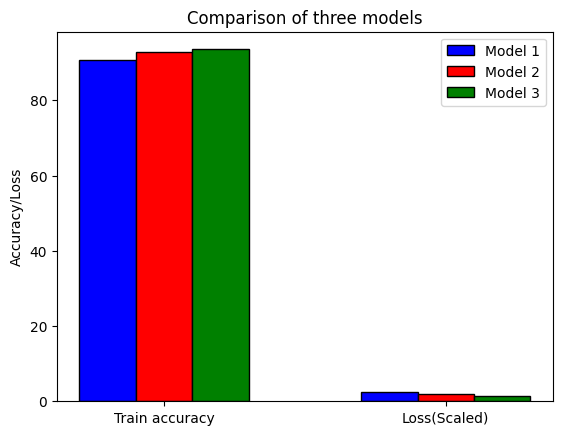

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# data for the three models Losses are multiplied by 10 for better representation
model1_data = [90.6, 2.376177295280451]
model2_data = [92.78, 1.9282423756311617]
model3_data = [93.55, 1.5108777089115907]

# plot the bar graph
bar_width = 0.2
epochs = ['Train accuracy', 'Loss(Scaled)']
r1 = np.arange(len(epochs))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.bar(r1, model1_data, color='blue', width=bar_width, edgecolor='black', label='Model 1')
plt.bar(r2, model2_data, color='red', width=bar_width, edgecolor='black', label='Model 2')
plt.bar(r3, model3_data, color='green', width=bar_width, edgecolor='black', label='Model 3')

# add labels and legend
plt.xticks([r + bar_width for r in range(len(epochs))], epochs)
plt.ylabel('Accuracy/Loss')
plt.title('Comparison of three models')
plt.legend()

plt.show()


**Result:** 

Ran the model for 100 Epochs and got the Test accuracy 93.55 which was the highest as compared to the previous 2 models.
